# Comparison of Image Compression Techniques
- JPEG (1992 original standard) - DCT and quantization vs. thresholding
- JPEG2000 - only look at lossy standard. DWT -> quantization -> run length encoding (not spec)
- JPEGThreshold - variant w/ thresholding
- SVD (not good)
- DWT->SVD->QUANT->IDWT (not good)
- SVD->DWT->QUANT->IDWT (same as if DWT and SVD are switched)

In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using FFTW
using Images
using TestImages
using Wavelets

In [141]:
function threshold2D!(x, compressionRatio)
    dimensions = size(x)
    (compressionRatio > 1) && (compressionRatio = 1)
    num_threshold = round(Int, length(x)*compressionRatio)
    ind = sortperm(vec(x), alg=QuickSort, by=abs)
    for i = 1:length(x) - num_threshold
        zero_idx = ind[i]
        row = rem(zero_idx-1, size(x)[1])+1
        col = div(zero_idx-1, size(x)[1])+1
        x[row, col] = 0
    end
end;

function RGB2YpCbCr(rgbImg)
    r = red.(rgbImg)
    g = green.(rgbImg)
    b = blue.(rgbImg)
    YpCbCr = zeros(size(r, 1), size(r, 2), 3)
    YpCbCr[:,:,1] = 16 .+ (r.*65.481 .+ g.*128.533 .+ b.*24.966)
    YpCbCr[:,:,2] = 128 .+ (r.*(-37.797) .- g.*74.203 .+ b.*112)
    YpCbCr[:,:,3] = 128 .+ (r.*112 .- g.*93.786 .- b.*18.214)
    return YpCbCr
end


function YpCbCr2RGB(YpCbCr)
    RGB = zeros(size(r, 1), size(r, 2), 3)
    RGB[:,:,1] = 298.082/256 .* YpCbCr[:,:,1] .+ 408.583/256 .* YpCbCr[:,:,3] .- 222.921
    RGB[:,:,2] = 298.082/256 .* YpCbCr[:,:,1] .- 100.291/256 .* YpCbCr[:,:,2] .- 208.120/256 .* YpCbCr[:,:,3] .+ 135.576
    RGB[:,:,3] = 298.082/256 .* YpCbCr[:,:,1] .+ 512.412/256 .* YpCbCr[:,:,2] .- 276.836
    return RGB./256
end

function RGBDistance(rgb1, rgb2)

YpCbCr2RGB (generic function with 1 method)

# JPEG Image Compression With DCT (Standard Quantization and Hard Thresholding)

In [142]:
function makeQuantizationTable(qualityFactor)
    # base (Q = 50) quantization table
    Tb = [
        16    11    10    16    24    40    51    61;
        12    12    14    19    26    58    60    55;
        14    13    16    24    40    57    69    56;
        14    17    22    29    51    87    80    62;
        18    22    37    56    68   109   103    77;
        24    35    55    64    81   104   113    92;
        49    64    78    87   103   121   120   101;
        72    92    95    98   112   100   103    99
    ]
    if (qualityFactor < 50)
        S = 5000/qualityFactor
    else
        S = 200 - 2*qualityFactor
    end
    Ts = floor.((Tb.*S .+ 50) ./ 100)
    Ts[Ts .== 0] .= 1;
    return Ts
end

function zigzagIndices(k, tileSize)
    if k >= div(tileSize * (tileSize + 1), 2)
        i, j = zigzagIndices(tileSize * tileSize - k - 1, tileSize)
        return tileSize - i - 1, tileSize - j - 1
    end
    i = floor(Int,div((sqrt(1 + 8 * k) - 1), 2))
    j = k - div(i *(i + 1), 2)
    if mod(i, 2) != 0
        return j, i - j
    else
        return i - j, j
    end
end

function jpegQuantCompress(rgbImg, qualityFactor)
    nnzQuant = 0
    nnzOrig = 0
    bits = 0
    quant = makeQuantizationTable.(qualityFactor)
    YpCbCr = RGB2YpCbCr(rgbImg)
    tileSize = 8 # forced to 8 because of quantization table size
    # make zigzag matrix
    zigzag = zeros(Int, tileSize, tileSize)
    for k=0:tileSize*tileSize-1
        i, j = zigzagIndices(k, tileSize)
        zigzag[i + 1, j + 1] = k+1
    end
    flatDct = zeros(tileSize*tileSize)
    flatQuant = zeros(tileSize*tileSize, 3)
    for channel = 1:3
        for idct=1:tileSize
            for jdct=1:tileSize
                flatQuant[zigzag[idct, jdct], channel] = quant[channel][idct, jdct];
            end
        end
    end
    # will chop off excess image if image side-length isn't a multiple of tileSize
    for i = 1:div(size(YpCbCr, 1),tileSize)
        for j = 1:div(size(YpCbCr, 2),tileSize)
            for channel in 1:3
                slice = view(YpCbCr, (i-1)*tileSize+1:i*tileSize, (j-1)*tileSize+1:j*tileSize, channel)
                FFTW.dct!(slice);
                nnzOrig += count(i->(i!=0), slice)
                # needs to be round, not floor/ceil
                # https://farid.berkeley.edu/downloads/publications/tr18.pdf
                slice[:,:] = sign.(slice).*floor.(abs.(slice)./quant[channel]);
                nnzQuant += count(i->(i!=0), slice)
                # unroll DCT and calculate number of bits required to store run length encoding
                for idct=1:tileSize
                    for jdct=1:tileSize
                        flatDct[zigzag[idct, jdct]] = slice[idct, jdct];
                    end
                end
                finalZero = false
                for idct=1:tileSize*tileSize
                    finalZero = true
                    if flatDct[idct] != 0
                        finalZero = false
                        bits += ceil(log2(tileSize*tileSize-1)) + ceil(log2(round(255/flatQuant[idct, channel])))
                    end
                end
                if finalZero
                    # if final element in tile is zero, then we need to include it anyway
                    bits += ceil(log2(tileSize*tileSize-1))
                end
                slice[:,:] = quant[channel].*slice
                FFTW.idct!(slice)
                YpCbCr[(i-1)*tileSize+1:i*tileSize, (j-1)*tileSize+1:j*tileSize, channel] = slice;
            end
        end
    end
    RGB = YpCbCr2RGB(YpCbCr)
    return RGB, bits, nnzQuant, nnzOrig
end

function jpegThreshCompress(rgbImg, tileSize, compRatio)
    nnzThresh = 0
    nnzOrig = 0
    bits = 0
    YpCbCr = RGB2YpCbCr(rgbImg)
    zigzag = zeros(Int, tileSize, tileSize)
    for k=0:tileSize*tileSize-1
        i, j = zigzagIndices(k, tileSize)
        zigzag[i + 1, j + 1] = k+1
    end
    flatDct = zeros(tileSize*tileSize)
    # will chop off excess image if image side-length isn't a multiple of tileSize
    for i = 1:div(size(rgbImg, 1),tileSize)
        for j = 1:div(size(rgbImg, 2),tileSize)
            for channel = 1:3
                slice = view(YpCbCr, (i-1)*tileSize+1:i*tileSize, (j-1)*tileSize+1:j*tileSize, channel)
                FFTW.dct!(slice);
                nnzOrig += count(i->(i!=0), slice)
                threshold2D!(slice, compRatio[channel]);
                nnzThresh += count(i->(i!=0), slice)
                # unroll DCT and calculate number of bits required to store run length encoding
                for idct=1:tileSize
                    for jdct=1:tileSize
                        flatDct[zigzag[idct, jdct]] = slice[idct, jdct];
                    end
                end
                for idct=1:tileSize*tileSize
                    if flatDct[idct] != 0
                        bits += ceil(log2(tileSize*tileSize-1)) + ceil(log2(256))
                    end
                end
                FFTW.idct!(slice);
                YpCbCr[(i-1)*tileSize+1:i*tileSize, (j-1)*tileSize+1:j*tileSize, channel] = slice;
            end
        end
    end
    RGB = YpCbCr2RGB(YpCbCr)
    return RGB, bits, nnzThresh, nnzOrig
end

jpegThreshCompress (generic function with 1 method)

Original Image


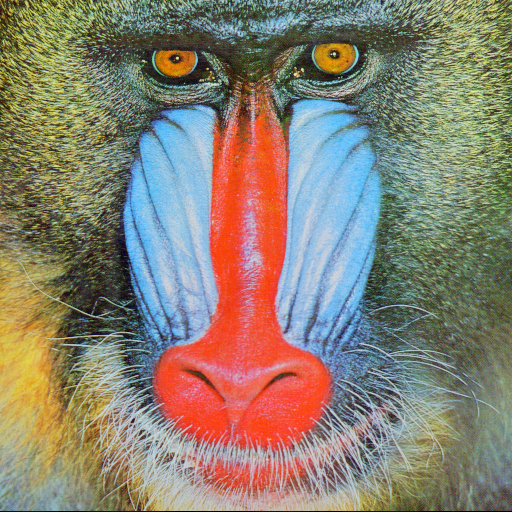


JPEG Quantization:


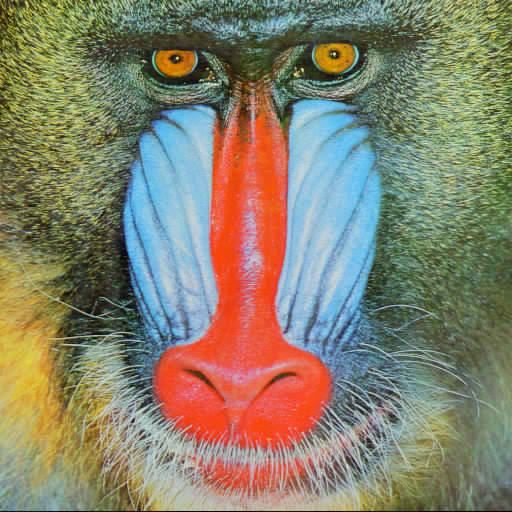

compression ratio: 0.1587985356648763 (6:1), nnz ratio = 0.106781005859375
RGB-MSE: 0.0029386436565000448
Y-MSE: 0.0011684161888351906
RGB-PSNR: 25.318530738111527
Y-PSNR: 29.32402434347337

Tiled DCT Hard Thresholding:


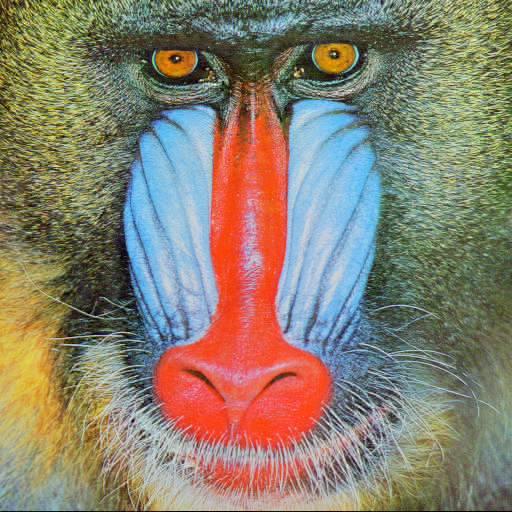

compression ratio: 0.23697916666666666 (4:1), nnz ratio = 0.13541666666666666
RGB-MSE: 0.0024343221077436326
Y-MSE: 0.0011834825015277573
RGB-PSNR: 26.136219567714498
Y-PSNR: 29.268381589821463


In [154]:
#img = Gray.(testimage("airplaneF16"))
img = Gray.(testimage("mandrill"))
#img = Gray.(testimage("peppers"))

img = testimage("mandrill")
# standard JPEG (1992)
println("Original Image");
display(img)
quantImg, bits, nnzQ, nnzO = jpegQuantCompress(img, [75 40 40])
cr = bits / (8*length(quantImg))
ypcbcrOrig = RGB2YpCbCr(img)
rgbQuantImg = RGB.(quantImg[:,:,1], quantImg[:,:,2], quantImg[:,:,3])
ypcbcrQuant = RGB2YpCbCr(rgbQuantImg)
println("\nJPEG Quantization:");
display(rgbQuantImg)
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzQ/nnzO)
rgbMSE = 1/length(quantImg).*sum((red.(img) - quantImg[:,:,1]).^2 .+ (green.(img) - quantImg[:,:,2]).^2 .+ (blue.(img) - quantImg[:,:,3]).^2)
yMSE = 3/length(quantImg).*sum((ypcbcrOrig[:,:,1] - ypcbcrQuant[:,:,1]).^2)./(255^2)
println("RGB-MSE: ", rgbMSE);
println("Y-MSE: ", yMSE);
println("RGB-PSNR: ", -10*log10(rgbMSE));
println("Y-PSNR: ", -10*log10(yMSE));

# hard thresholding of entire image DCT
println("\nTiled DCT Hard Thresholding:");
threshImg, bits, nnzQ, nnzO = jpegThreshCompress(img, 8, [0.22 0.1 0.1])
cr = bits / (8*length(threshImg))
ypcbcrOrig = RGB2YpCbCr(img)
rgbThreshImg = RGB.(threshImg[:,:,1], threshImg[:,:,2], threshImg[:,:,3])
ypcbcrThresh = RGB2YpCbCr(rgbThreshImg)
display(rgbThreshImg)
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzQ/nnzO)
rgbMSE = 1/length(quantImg).*sum((red.(img) - threshImg[:,:,1]).^2 .+ (green.(img) - threshImg[:,:,2]).^2 .+ (blue.(img) - threshImg[:,:,3]).^2)
yMSE = 3/length(quantImg).*sum((ypcbcrOrig[:,:,1] - ypcbcrThresh[:,:,1]).^2)./(255^2)
println("RGB-MSE: ", rgbMSE);
println("Y-MSE: ", yMSE);
println("RGB-PSNR: ", -10*log10(rgbMSE));
println("Y-PSNR: ", -10*log10(yMSE));

# JPEG2000 Compression With Discrete Wavelet Transform

In [76]:
function countRLEBits(imgArray, subbandQuantization, numSubbandLevels, tileSize)
    bits = 0
    if imgArray[1, 1] != 0
        bits += 8
    end
    for i=1:numSubbandLevels
        wlo = 2^(i-1)+1
        whi = 2^i
        dataBits = ceil(log2(256/subbandQuantization[i]))
        if wlo - 1 > tileSize
            runBits = ceil(log2(tileSize*tileSize))
            bitsPerNonZero = runBits + dataBits
            numTiles = div(wlo-1, tileSize)
            for subband = 1:3
                if subband == 1
                    xOffset = 1
                    yOffset = wlo
                elseif subband == 2
                    xOffset = wlo
                    yOffset = wlo
                else
                    xOffset = wlo
                    yOffset = 1
                end
                finalZero = false
                for i = 1:numTiles
                    for j = 1:numTiles
                        for iTile = 0:tileSize-1
                            for jTile = 0:tileSize-1
                                x = (i-1)*tileSize + iTile + xOffset
                                y = (j-1)*tileSize + jTile + yOffset
                                finalZero = true
                                if imgArray[x, y] != 0
                                    finalZero = false
                                    bits += bitsPerNonZero
                                end
                            end
                        end
                        if finalZero
                            # don't need bits for data because decoder can sum previous RLE lengths
                            # in this tile with this last piece of data and determine that the final
                            # value was zero
                            bits += runBits
                        end
                    end
                end
            end
        else
            runBits = ceil(log2((wlo-1)*(wlo-1)))
            bitsPerNonZero = runBits + dataBits
            finalZero = false
            for i = 1:whi
                for j = 1:whi
                    if i < wlo && j < wlo
                        # only count bits for current subband
                        continue
                    end
                    finalZero = true
                    if imgArray[i, j] != 0
                        finalZero = false
                        bits += bitsPerNonZero
                    end
                end
            end
            if finalZero
                bits += runBits
            end
        end
    end
    return bits
end

function waveletThresholdCompress!(imgArray, wt, compRatio, rleTileSize)
    imgArray[:,:] = (imgArray .* 255) .- 128
    dwt!(imgArray, wt)
    dwtHOrig = entropy(log2, imgArray)
    nnzOrig = count(i->(i!=0), imgArray)
    threshold2D!(imgArray, compRatio)
    dwtHThresh = entropy(log2, imgArray)
    nnzThresh = count(i->(i!=0), imgArray)
    # zigzag traverse subbands of wavelet tree to do run length encoding
    # for each subband, just traverse 2D array normally (row-major/col-major order)
    # get number of subband levels (e.g. 9 for 512x512 image)
    numSubbandLevels = maxtransformlevels(imgArray)
    bits = countRLEBits(imgArray, ones(numSubbandLevels), numSubbandLevels, rleTileSize)
    idwt!(imgArray, wt)
    imgArray[:,:] = (imgArray .+ 128) ./ 255
    return bits, nnzThresh, nnzOrig, dwtHThresh, dwtHOrig
end

function waveletQuantizedCompress!(imgArray, wt, quantTable, rleTileSize)
    imgArray[:,:] = (imgArray .* 255) .- 128
    dwt!(imgArray, wt)
    dwtHOrig = entropy(log2, imgArray)
    nnzOrig = count(i->(i!=0), imgArray)
    # create wavelet transform quantization table
    # Do subband scalar quantization (https://www2.seas.gwu.edu/~ayoussef/papers/FingerPrintWSQ-chapter.pdf)
    # get number of subband levels (e.g. 9 for 512x512 image)
    numSubbandLevels = maxtransformlevels(imgArray)
    # do strong quantization of highest subband levels
    # don't quantize DC subband
    for i=1:numSubbandLevels
        wlo = 2^(i-1)+1
        whi = 2^i
        subband = view(imgArray, wlo:whi, 1:whi)
        imgArray[wlo:whi, 1:whi] = sign.(subband) .* quantTable[i] .* floor.(abs.(subband) ./ quantTable[i]);
        subband = view(imgArray, 1:wlo-1, wlo:whi)
        imgArray[1:wlo-1, wlo:whi] = sign.(subband) .* quantTable[i] .* floor.(abs.(subband) ./ quantTable[i]);
    end
    dwtHQuant = entropy(log2, imgArray)
    nnzQuant = count(i->(i!=0), imgArray)
    bits = countRLEBits(imgArray, quantTable, numSubbandLevels, rleTileSize)
    idwt!(imgArray, wt)
    imgArray[:,:] = (imgArray .+ 128) ./ 255
    return bits, nnzQuant, nnzOrig, dwtHQuant, dwtHOrig
end

function waveletTiledQuantizedCompress!(imgArray, wt, quantTable, tileSize)
    bits = 0
    nnzQuant = 0
    nnzOrig = 0
    dwtHQuant = 0
    dwtHOrig = 0
    for i = 1:div(size(imgArray, 1),tileSize)
        for j = 1:div(size(imgArray, 2),tileSize)
            slice = imgArray[(i-1)*tileSize+1:i*tileSize, (j-1)*tileSize+1:j*tileSize]
            b, nQ, nO, HQ, HO = waveletQuantizedCompress!(slice, wt, quantTable, tileSize)
            imgArray[(i-1)*tileSize+1:i*tileSize, (j-1)*tileSize+1:j*tileSize] = slice
            bits += b
            nnzQuant += nQ
            nnzOrig += nO
            dwtHQuant += HQ
            dwtHOrig += HO
        end
    end
    dwtHQuant /= length(imgArray)/(tileSize*tileSize)
    dwtHOrig /= length(imgArray)/(tileSize*tileSize)
    return bits, nnzQuant, nnzOrig, dwtHQuant, dwtHOrig
end

waveletTiledQuantizedCompress! (generic function with 1 method)

Wavelet Thresholding


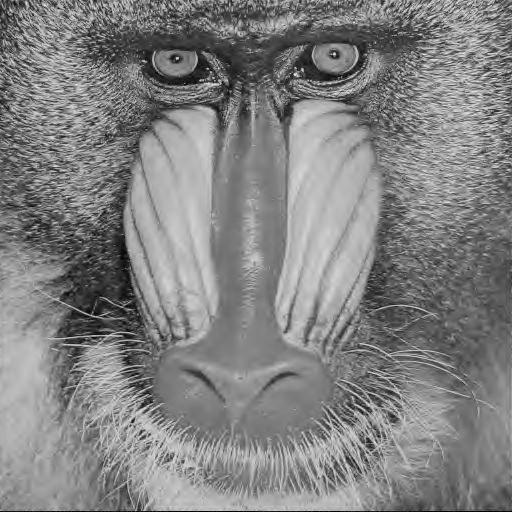

compression ratio: 0.35983753204345703 (3:1), nnz ratio = 0.13000106811523438
Original DWT entropy = 1.4240085179400765
Thresholded DWT entropy = 0.9112881109436135
MSE: 0.001800156431272626
PSNR: 27.446897536263695

Wavelet Thresholding with Tiled RLE


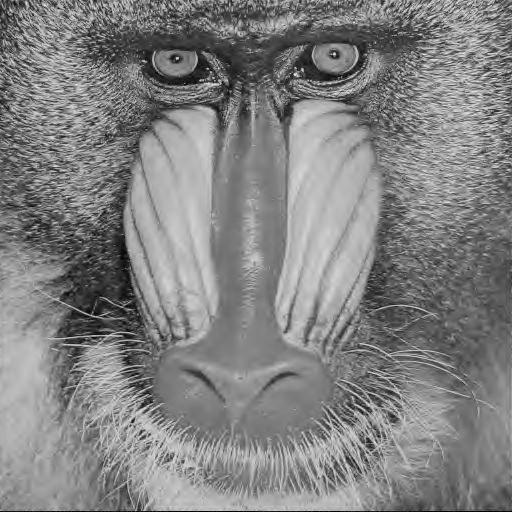

compression ratio: 0.2373523712158203 (4:1), nnz ratio = 0.13000106811523438
Original DWT entropy = 1.4240085179400765
Thresholded DWT entropy = 0.9112881109436135
MSE: 0.001800156431272626
PSNR: 27.446897536263695

Wavelet Quantization


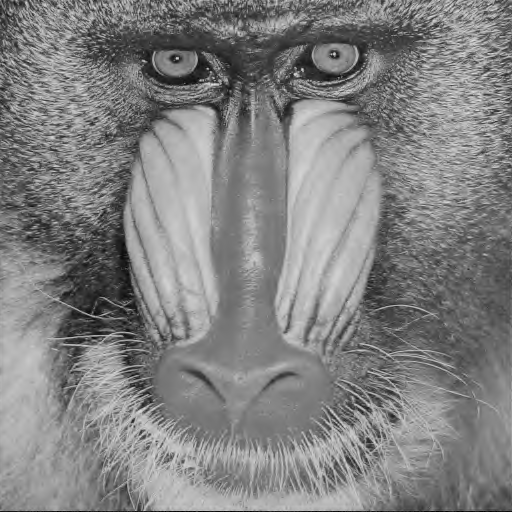

compression ratio: 0.39925479888916016 (3:1), nnz ratio = 0.17370223999023438
Original DWT entropy = 1.4240085179400765
Quantized DWT entropy = 0.9594462195084238
MSE: 0.0016722686123102903
PSNR: 27.76693961661069

Wavelet Quantization with Tiled RLE


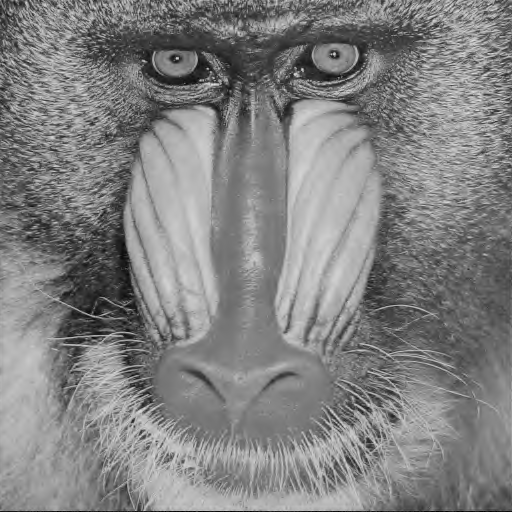

compression ratio: 0.2311077117919922 (4:1), nnz ratio = 0.17370223999023438
Original DWT entropy = 1.4240085179400765
Quantized DWT entropy = 0.9594462195084238
MSE: 0.0016722686123102903
PSNR: 27.76693961661069

Tiled Wavelet Quantization


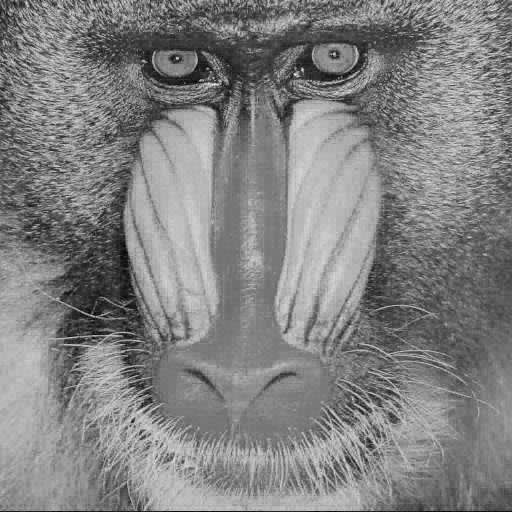

compression ratio: 0.19945573806762695 (5:1), nnz ratio = 0.22208404541015625
Original DWT entropy = 5.007319404957209
Quantized DWT entropy = 1.354683468861969
MSE: 0.0019100992940366268
PSNR: 27.189440559295864


In [77]:
# wavelet threshold compression
rawImg = convert(Array{Float32}, img)
wt = wavelet(WT.cdf97, WT.Lifting)
#wt = wavelet(WT.haar, WT.Lifting)
#wt = wavelet(WT.db2, WT.Lifting)
bits, nnzT, nnzO, dwtHThresh, dwtHOrig = waveletThresholdCompress!(rawImg, wt, 0.13, size(rawImg, 1))
cr = bits/(8*length(rawImg))
println("Wavelet Thresholding")
display(Gray.(rawImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzT/nnzO)
println("Original DWT entropy = ", dwtHOrig)
println("Thresholded DWT entropy = ", dwtHThresh)
mse = 1/length(rawImg).*sum((convert(Array{Float32}, img) - rawImg).^2)
println("MSE: ", mse);
println("PSNR: ", -10*log10(mse));

# wavelet threshold compression with tiled RLE
rawImg = convert(Array{Float32}, img)
wt = wavelet(WT.cdf97, WT.Lifting)
#wt = wavelet(WT.haar, WT.Lifting)
#wt = wavelet(WT.db2, WT.Lifting)
bits, nnzT, nnzO, dwtHThresh, dwtHOrig = waveletThresholdCompress!(rawImg, wt, 0.13, 8)
cr = bits/(8*length(rawImg))
println("\nWavelet Thresholding with Tiled RLE")
display(Gray.(rawImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzT/nnzO)
println("Original DWT entropy = ", dwtHOrig)
println("Thresholded DWT entropy = ", dwtHThresh)
mse = 1/length(rawImg).*sum((convert(Array{Float32}, img) - rawImg).^2)
println("MSE: ", mse);
println("PSNR: ", -10*log10(mse));

# wavelet quantization
rawImg = convert(Array{Float32}, img)
wt = wavelet(WT.cdf97, WT.Lifting)
# adaptive quantization?
quantTable = [1 1 1 1 1 7 22 24 26]
bits, nnzQ, nnzO, dwtHQuant, dwtHOrig = waveletQuantizedCompress!(rawImg, wt, quantTable, size(rawImg, 1))
cr = bits/(8*length(rawImg))
println("\nWavelet Quantization")
display(Gray.(rawImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzQ/nnzO)
println("Original DWT entropy = ", dwtHOrig)
println("Quantized DWT entropy = ", dwtHQuant)
mse = 1/length(rawImg).*sum((convert(Array{Float32}, img) - rawImg).^2)
println("MSE: ", mse);
println("PSNR: ", -10*log10(mse));


# wavelet quantization with tiled RLE
rawImg = convert(Array{Float32}, img)
wt = wavelet(WT.cdf97, WT.Lifting)
# adaptive quantization?
quantTable = [1 1 1 1 1 7 22 24 26]
bits, nnzQ, nnzO, dwtHQuant, dwtHOrig = waveletQuantizedCompress!(rawImg, wt, quantTable, 8)
cr = bits/(8*length(rawImg))
println("\nWavelet Quantization with Tiled RLE")
display(Gray.(rawImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzQ/nnzO)
println("Original DWT entropy = ", dwtHOrig)
println("Quantized DWT entropy = ", dwtHQuant)
mse = 1/length(rawImg).*sum((convert(Array{Float32}, img) - rawImg).^2)
println("MSE: ", mse);
println("PSNR: ", -10*log10(mse));


# tiled wavelet quantization
rawImg = convert(Array{Float32}, img)
wt = wavelet(WT.cdf97, WT.Lifting)
# adaptive quantization?
#quantTable = [1 1 1 7 16 22 28]
quantTable = [1 16 32]
bits, nnzQ, nnzO, dwtHQuant, dwtHOrig = waveletTiledQuantizedCompress!(rawImg, wt, quantTable, 8)
cr = bits/(8*length(rawImg))
println("\nTiled Wavelet Quantization")
display(Gray.(rawImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzQ/nnzO)
println("Original DWT entropy = ", dwtHOrig)
println("Quantized DWT entropy = ", dwtHQuant)
mse = 1/length(rawImg).*sum((convert(Array{Float32}, img) - rawImg).^2)
println("MSE: ", mse);
println("PSNR: ", -10*log10(mse));

# SVD-based Quantization/Thresholding
Approach:
Compute DWT or DCT to get a transform of image, then compute SVD of transform to determine relevant components of image.
Then truncate transform to "relevant" portions with SVD.
Finally, do an inverse DWT or DCT to reconstruct the image from the truncated transform

Original Image


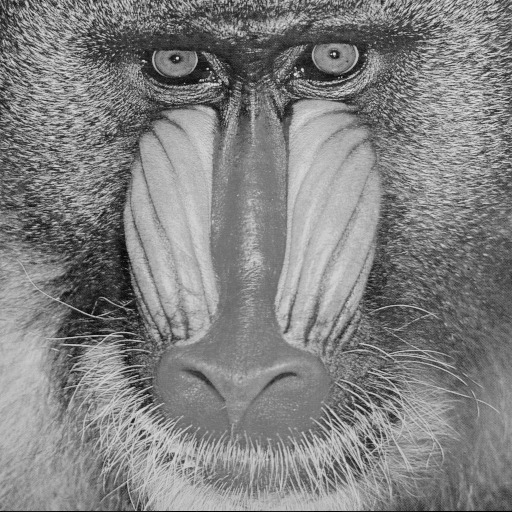


SVD-Only Compression


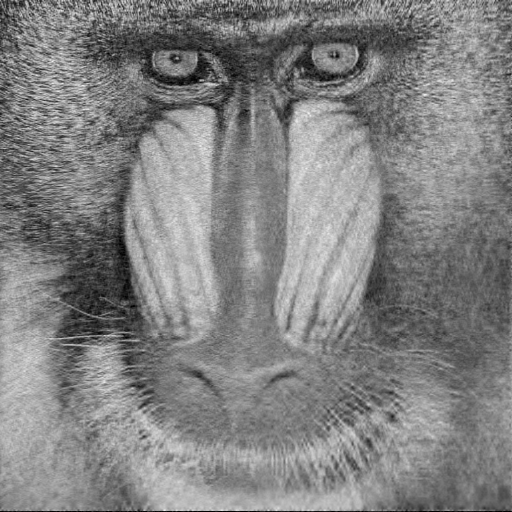

compression ratio: 0.19941329956054688
MSE: 0.005399832221589549
PSNR: 22.67619733949222

SVD+Thresholding (DWT->SVD->Thresh->IDWT) Compression


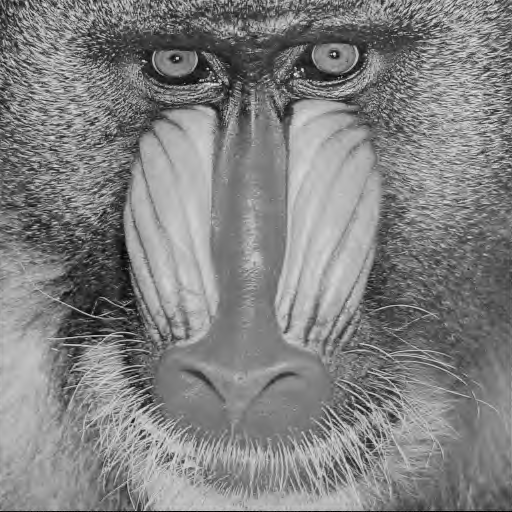

compression ratio: 0.17300033569335938
MSE: 0.0012586043054259475
PSNR: 29.001107869540718

SVD+Thresholding (SVD->DWT->Thresh->IDWT) Compression


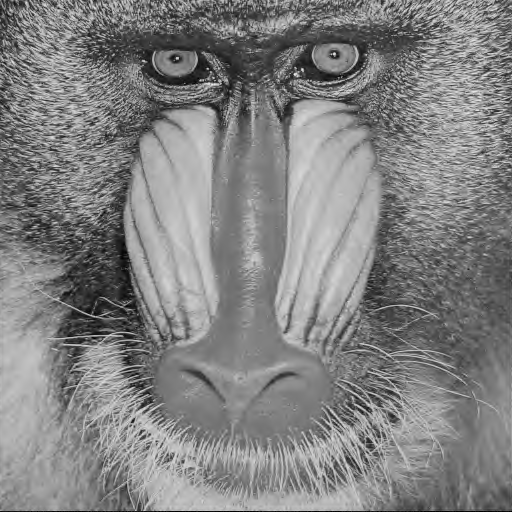

compression ratio: 0.17300033569335938
MSE: 0.0012587150676399467
PSNR: 29.00072568983886

Thresholding-Only Compression


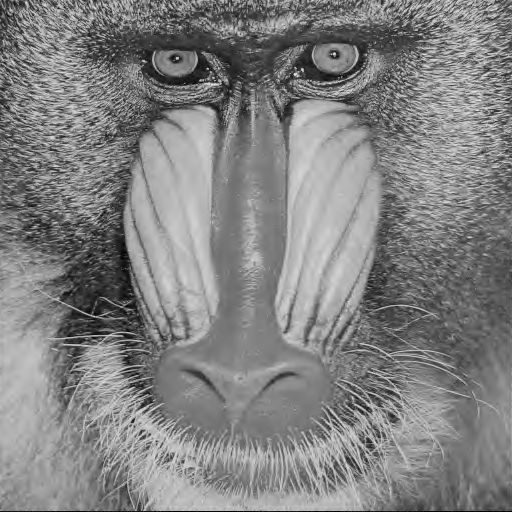

compression ratio: 0.48326778411865234 (2:1), nnz ratio = 0.17300033569335938
MSE: 0.001258414820767939
PSNR: 29.001761755247646


In [34]:
rawImg = convert(Array{Float32}, img)
println("Original Image");
display(img)
wt = wavelet(WT.cdf97, WT.Lifting)
wvltImg = dwt(rawImg, wt)
F = svd(wvltImg, full=true)
rankRatio = 0.10 # ratio of singular values to keep
(rankRatio > 1) && (rankRatio = 1)
num_threshold = round(Int, length(F.S)*rankRatio)
Snew = zeros(length(F.S))
for i=1:num_threshold
    Snew[i] = F.S[i]
end
svdCompDwt = F.U*Diagonal(Snew)*F.Vt
# compression ratio is different for SVD
cr = (num_threshold*sum(size(rawImg)) + num_threshold)/length(rawImg)
svdCompImg = idwt(svdCompDwt, wt);
println("\nSVD-Only Compression");
display(Gray.(svdCompImg))
println("compression ratio: ", cr)
mse = 1/length(svdCompImg).*sum((convert(Array{Float32}, img) - svdCompImg).^2)
println("MSE: ", mse);
println("PSNR: ", -10*log10(mse));

# next try hybrid method: moderate compression with SVD, then hard thresholding?
# perhaps an improvement, hard to tell
# with fine tuning of SVD compression, can achieve improvement in PSNR
# only very minimal improvement (~mdB) in PSNR --- no perceived impact
# however, most of the time, this underperforms just normal thresholding
# similar to: https://www.sciencedirect.com/science/article/pii/S1051200413001929

rawImg = convert(Array{Float32}, img)
wt = wavelet(WT.cdf97, WT.Lifting)
wvltImg = dwt(rawImg, wt)
nnzOrig = count(i->(i!=0), wvltImg);
F = svd(wvltImg, full=true)
compressionRatio = 0.90 # ratio of singular values to keep
(compressionRatio > 1) && (compressionRatio = 1)
num_threshold = round(Int, length(F.S)*compressionRatio)
Snew = zeros(length(F.S))
for i=1:num_threshold
    Snew[i] = F.S[i]
end
svdCompDwt = F.U*Diagonal(Snew)*F.Vt
threshold2D!(svdCompDwt, 0.173);
nnzSvd = count(i->(i!=0), svdCompDwt);
svdCompImg = idwt(svdCompDwt, wt);
println("\nSVD+Thresholding (DWT->SVD->Thresh->IDWT) Compression");
display(Gray.(svdCompImg));
println("compression ratio: ", nnzSvd/nnzOrig);
mse = 1/length(svdCompImg).*sum((convert(Array{Float32}, img) - svdCompImg).^2)
println("MSE: ", mse);
println("PSNR: ", -10*log10(mse));

# SVD then wavelet transform
rawImg = convert(Array{Float32}, img)
wvltImg = dwt(rawImg, wt)
nnzOrig = count(i->(i!=0), wvltImg);
F = svd(rawImg, full=true)
svdRatio = 0.90
numThresh = round(Int, length(F.S)*svdRatio)
Snew = zeros(length(F.S))
for i = 1:numThresh
    Snew[i] = F.S[i]
end
svdComp = F.U*Diagonal(Snew)*F.Vt
wt = wavelet(WT.cdf97, WT.Lifting)
wvltImg = dwt(svdComp, wt)
threshold2D!(wvltImg, 0.173);
nnzThresh = count(i->(i!=0), wvltImg);
svdThreshImg = idwt(wvltImg, wt);
println("\nSVD+Thresholding (SVD->DWT->Thresh->IDWT) Compression");
display(Gray.(svdThreshImg));
println("compression ratio: ", nnzThresh/nnzOrig);
mse = 1/length(svdThreshImg).*sum((convert(Array{Float32}, img) - svdThreshImg).^2)
println("MSE: ", mse);
println("PSNR: ", -10*log10(mse));

# compare with normal thresholding in wavelet domain
rawImg = convert(Array{Float32}, img)
wt = wavelet(WT.cdf97, WT.Lifting)
bits, nnzT, nnzO = waveletThresholdCompress!(rawImg, wt, 0.173)
println("\nThresholding-Only Compression");
cr = bits/(8*length(rawImg))
display(Gray.(rawImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzT/nnzO)
mse = 1/length(rawImg).*sum((convert(Array{Float32}, img) - rawImg).^2)
println("MSE: ", mse);
println("PSNR: ", -10*log10(mse));

Original Image


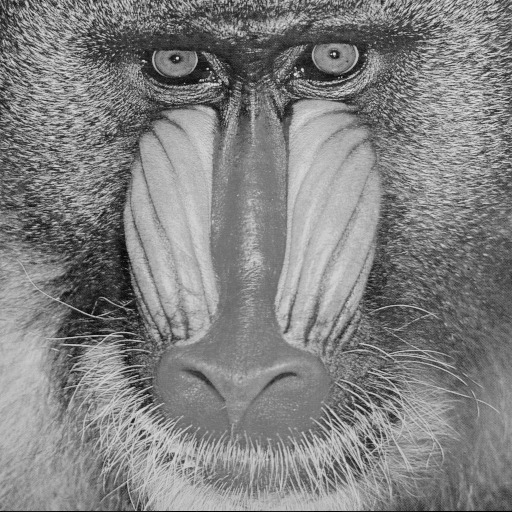

Wavelet Transform


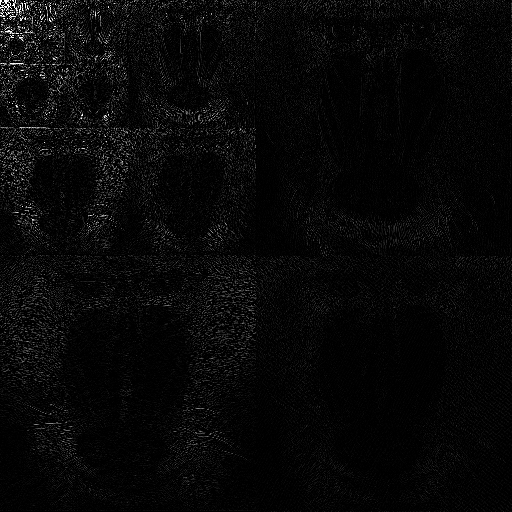

Log-amplitude Wavelet Transform


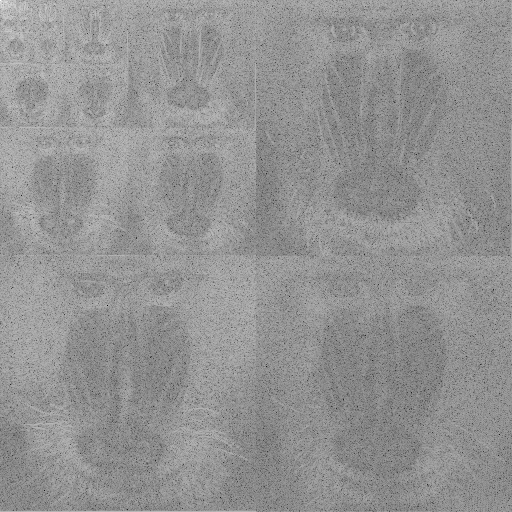

In [48]:
rawImg = convert(Array{Float32}, img)
println("Original Image");
display(img)
save("mandrill.png", Gray.(rawImg))
wt = wavelet(WT.cdf97, WT.Lifting)
dwt!(rawImg, wt)
println("Wavelet Transform");
maxDWT = maximum(rawImg)
minDWT = minimum(rawImg)
linDWT = (rawImg .- minDWT)./(maxDWT - minDWT)
display(Gray.(rawImg))
println("Log-amplitude Wavelet Transform");
logAbs = log2.(abs.(rawImg))
maxLog = maximum(logAbs)
minLog = minimum(logAbs)
logAbs = (logAbs .- minLog)./(maxLog - minLog)
display(Gray.(logAbs))

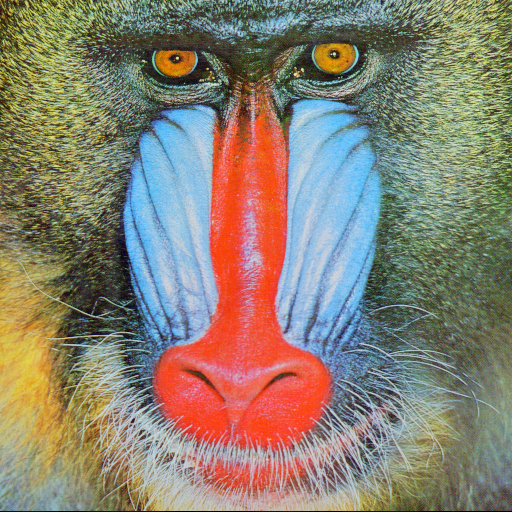

In [84]:
RGB.(red.(testimage("mandrill")), green.(testimage("mandrill")), blue.(testimage("mandrill")))

In [88]:
r = red.(testimage("mandrill"));
view(r, :, 1:5)

512×5 view(::Array{N0f8,2}, :, 1:5) with eltype N0f8:
 0.643  0.247  0.294  0.373  0.616
 0.471  0.529  0.216  0.294  0.455
 0.388  0.518  0.235  0.212  0.392
 0.251  0.588  0.443  0.196  0.318
 0.431  0.51   0.635  0.235  0.298
 0.38   0.322  0.702  0.318  0.29
 0.239  0.275  0.584  0.624  0.243
 0.212  0.247  0.451  0.733  0.373
 0.251  0.263  0.282  0.525  0.569
 0.216  0.212  0.2    0.29   0.616
 0.212  0.216  0.373  0.196  0.388
 0.2    0.231  0.357  0.231  0.243
 0.196  0.231  0.412  0.333  0.208
 ⋮                           
 0.561  0.525  0.518  0.467  0.435
 0.518  0.51   0.498  0.42   0.404
 0.502  0.498  0.455  0.439  0.471
 0.416  0.447  0.494  0.463  0.471
 0.459  0.471  0.447  0.475  0.537
 0.42   0.416  0.451  0.486  0.482
 0.38   0.388  0.451  0.49   0.525
 0.365  0.361  0.455  0.553  0.506
 0.376  0.463  0.522  0.447  0.471
 0.475  0.482  0.486  0.49   0.404
 0.494  0.459  0.475  0.416  0.396
 0.035  0.039  0.043  0.047  0.047

In [125]:
display(makeQuantizationTable.([10 50 100])[2])

8×8 Matrix{Float64}:
 16.0  11.0  10.0  16.0   24.0   40.0   51.0   61.0
 12.0  12.0  14.0  19.0   26.0   58.0   60.0   55.0
 14.0  13.0  16.0  24.0   40.0   57.0   69.0   56.0
 14.0  17.0  22.0  29.0   51.0   87.0   80.0   62.0
 18.0  22.0  37.0  56.0   68.0  109.0  103.0   77.0
 24.0  35.0  55.0  64.0   81.0  104.0  113.0   92.0
 49.0  64.0  78.0  87.0  103.0  121.0  120.0  101.0
 72.0  92.0  95.0  98.0  112.0  100.0  103.0   99.0